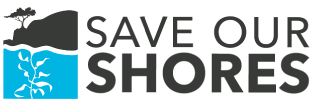

# Visualizations of Save Our Shores Cleanup Data 2013-2022

[Save Our Shores](https://saveourshores.org) (SOS) is a non-profit dedicated to ocean conservation in the Monterey Bay through education, advocacy, and beach cleanups. SOS organize many cleanup events every year, and they also coordinate over 60 cleanup sites around the Monterey Bay Marine National Sanctuary for the Annual Coastal Cleanup Day in September every year. For each event they record data such as location, number of volunteers, duration, weight of trash and recycling, and types of items cleaned up, and data has been collected since 2013.

This creates a rich data set that can be used to help drive policy changes, e.g. around single use plastic. The National Oceanic and Atmospheric Administration (NOAA) used the SOS data, along with other data sets, in their recent report ["Marine debris on the shoreline of Monterey Bay National Marine Sanctuary: An assessment of behaviors contributing to marine debris, categories & composition, spatial distribution, and predictor variables"](https://marinedebris.noaa.gov/other-reports/marine-debris-shoreline-monterey-bay-national-marine-sanctuary-assessment-behaviors). In it, they analyzed what types of trash are most prevalent, what activities they stem from, as well as exploring predictors of marine debris and suggesting recommendations.
When possible, the debris categories in the SOS data set have been organized to match those in NOAA's Monterey Bay National Marine Sanctuary Marine Debris report. There are some open questions, such as ambiguous category names and unknown materials. For full transparency, the configuration YAML file for categorizing items, and the code used for extracting, transforming and loading data can be seen in [in this GitHub repository](https://github.com/jennyfolkesson/cleanupShores).

A current focus for SOS is cigarette butt waste. [Cigarette butts are prevalent on our beaches and negatively impacts our ecosystems](https://www.theguardian.com/environment/2022/aug/18/cigarette-butts-how-the-no-1-most-littered-objects-are-choking-our-coasts). Filters were added to cigarette to alleviate concers about lung cancer risk, but [may in fact increase harm](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9340047) by giving smokers a false sense of security. Since cigarette butts don't seem to benefit smokers and they wreak havoc on the environment, it raises the question of why they are tolerated in the first place.

In this notebook, the SOS data set is analyzed by intermingling code, graphs and a discussion of the findings. I will first show how the data is structured, followed by visualizing total debris numbers for all years grouped by material, activity and cleanup site. After that I look at the numbers longitudinally, followed by an analysis of the relationship between number of volunteers and number of debris items. I then revisit the longitudinal evaluation of debris plotted on a per volunteer basis. Finally I look at debris caused by smoking more specifically.

Note: since many graphs are interactive, this document is best viewed as an html or with a notebook viewer. You can view this notebook online [here.](https://nbviewer.org/github/jennyfolkesson/saveOurShores/blob/main/SOS_cleanup_data.ipynb?flush_cache=True)

In [1]:
import circlify
import glob
import numpy as np
import os
import pandas as pd
import plotly
import plotly.express as px
import plotly.graph_objects as go
from pprint import pprint
import tabulate

import cleanup as cleanup 
import graphs as graphs

import plotly.io as pio
from plotly.offline import init_notebook_mode

pio.renderers.default = "notebook_connected"
init_notebook_mode(connected=True)

The SOS data has been stored in 1-2 xslx files for each year, with a wide variety of item names, types and site names. In some files rows and columns are flipped. The function call below will read the file where data from all years are combined, or create the file and save it if it is't in the directory already. The function call read_data will, in addition to individual xslx files, read a [config file](https://github.com/jennyfolkesson/saveOurShores/blob/main/column_categories.yml) which helps organize trash categories.

In [2]:
# The directory is named 2013-22 because I got it before I got data from 2023
data_dir = '/Users/jenny.folkesson/Data/SOS Cleanup Data 2013-2022'
sos_data, col_config = cleanup.read_data_and_config(data_dir)

Below you can see the structure of the combined data set for all years, which is is a Pandas DataFrame. The first five rows are displayed.

In [3]:
sos_data.head()

,Date,Cleanup Site,Data Collection,Duration (Hrs),Adult Volunteers,Youth Volunteers,Trash (lbs),Recycling (lbs),County/City,Type Of Cleanup,...,Other,Nails,Cleaned Size (Sq Miles),Foil,Bikes,Car Parts,Footwear,Beverage Bottles,Total Items,Total Volunteers
0,2013-01-12,Del Monte Beach,NaN,2.0,35.0,NaN,119.0,28.0,Monterey/Monterey,NaN,...,50.0,6.0,0.0,16.0,2.0,0.0,1.0,NaN,3983.0,35.0
1,2013-01-12,Manresa State Beach,NaN,2.0,24.0,NaN,20.0,11.0,Watsonville/Santa Cruz County,NaN,...,24.0,33.0,2.0,109.0,0.0,0.0,59.0,NaN,6228.0,24.0
2,2013-01-18,New Brighton State Beach,NaN,2.0,32.0,NaN,5.0,0.0,Santa Cruz/Santa Cruz,NaN,...,3.0,0.0,1.0,6.0,0.0,2.0,0.0,NaN,100.0,32.0
3,2013-01-18,Seabright State Beach,NaN,2.0,40.0,NaN,40.0,20.0,Santa Cruz/Santa Cruz,NaN,...,19.0,0.0,0.0,1.0,3.0,0.0,3.0,NaN,395.0,40.0
4,2013-01-19,Seacliff State Beach,NaN,3.0,51.0,NaN,33.0,5.0,Aptos/Santa Cruz,NaN,...,11.0,2.0,2.0,35.0,0.0,0.0,4.0,NaN,2383.0,51.0


There's also a config file that describes what each of the column names of the sos_data is in further detail. Each column name has following characteristics:

* **name** Column name
* **sources** Potential source names in various spreadsheets throughout the years
* **type** Data type (datetime, str, int, float)
* **required** Indicates if column is required to analyze the data (boolean)
* **material** The material the debris item is made from (plastic, wood, glass, metal, mixed). NA for columns that are not items
* **activity** The activity the debris item stems from (Various, Eating/Drinking, Dumping/Disaster, 'Smoking', 'Hygiene')

In [4]:
col_config.head()

,name,sources,type,required,material,activity
0,Date,"['Date', 'Date Of Cleanup Event/Fecha', 'Clean...",datetime,True,NaN,NaN
1,Cleanup Site,"['Cleanup Site', 'Cleanup Site/Sitio De Limpie...",str,True,NaN,NaN
2,Cleaned Size (Sq Miles),"['Cleaned Size (Sq Miles)', 'Estimated Size Of...",int,False,NaN,NaN
3,Data Collection,"['Data Collection', 'Data Collection Method']",str,False,NaN,NaN
4,Duration (Hrs),"['Duration (Hrs)', 'Total Cleanup Duration (Hr...",int,True,NaN,NaN


# Total Amount of Debris Collected by Save Our Shores in the Years 2013-23

We'll start with an overview of the sum of all the debris collected throughout the years, including the most common trash categories, the most common cleanup sites, and trash categories organized by activity.

## Debris Organized by Material

The graph below shows the total amount of items for each debris category. This is a circle packing graph, where circle areas are proportional to amount they're describing. The location of the circles is determined by a heuristic that aims to arrange circles of varying sizes within a larger circle perimeter to maximize circle density. When circles are too small to display the text within them, the text has been removed with the motivation that larger circles require more immediate attention. Instead you can hover over the circle to see the item category and number if you're vieving an [interactive version of this document.](https://nbviewer.org/github/jennyfolkesson/saveOurShores/blob/main/SOS_cleanup_data.ipynb?flush_cache=True)
The circles are color coded based on their material, with the categories **Mixed**, **Wood**, **Glass**, **Metal**, **Cloth** and **Plastic**.

In [5]:
# Instantiate graph making object
graph_maker = graphs.GraphMaker(data_dir, sos_data, col_config)

In [6]:
fig = graph_maker.circle_packing_graph(plot_colors=None)
fig.show()

The circle packing graph above shows the total number of items cleaned up by Save Our Shores 2013-2023, organized by debris categories and color coded by material. The area of the circle is proportional to the number of items cleaned up. In circles too small to fit the item name and quanitity inside, you can hover over the center of the circle to find that information. More than one circle with the same category name (e.g. Bottle Caps) are differentiated by material.

The color coding of the circles makes it obvious that plastic (in red) is by far the most common material of all the marine debris cleaned up by SOS. This aligns with findings that [80% of marine debris is made up of plastic](https://oceanliteracy.unesco.org/plastic-pollution-ocean/).

## Debris Organized by Activity

In [NOAA's marine debris report](https://marinedebris.noaa.gov/other-reports/marine-debris-shoreline-monterey-bay-national-marine-sanctuary-assessment-behaviors-contributing-marine-debris-categories-composition-spatial-distribution-and-predictor-variables), in Section 3, trash is organized into the following activities:

* **Eating & Drinking:** Associated trash categories include utensils and plates, take-out food containers, bottles, straws, and wrappers.
* **Smoking:** Trash left behind from smoking cigarettes, cigars, and vaping included butts, packaging, containers, and other smoking items.
* **Personal Hygiene:** Items include any personal protective or sanitary products such as face masks, gloves, condoms, tampons, diapers and syringes.
* **Recreation:** Items associated with recreation on the beach or elsewhere (other than fishing) include balloons, toys, clothing, and dog waste bags.
* **Dumping and Disaster:** Industrial and household waste dumping includes trash that may originate from unintentional or illegal dumping. This category also includes items resulting from storm damage, coastal erosion, or degrading harbors. Items include appliances, construction
material, and tires.
* **Various:** Trash that could have originated from any one of the other six activities but could not be identified with a specific activity. Examples include packaging, caps and bottles that may not have contained beverages, and fragmented pieces of plastic, glass, or metal.

Here, SOS cleanup data is categorized by activity and displayed in a bar graph. It's inspired by Figure 10 in Section 3 of NOAA's report, but the pie chart is replaced with a bar chart for (in my opinion) more easily interpretable results. Activity names are sligthy modified to **Eating/Drinking**, **Smoking**, **Hygiene**, **Recreation**, **Dumping/Disaster** and **Various**.

In [7]:
fig = graph_maker.activity_graph()
fig.show()

Eating and drinking contributed to the most marine debris of all the recognizable activites (which doesn't include Various). After that comes smoking, and the vast majority of Smoking items are cigarette butts. Recreation, Dumping/Disaster, Hygiene and Fishing resulted in much fewer debris items than the other two recognizable activities.

The fact that the single largest trash item from any recognizable activity is cigarett butts is striking, since only about 10% of Californians smoke but we all eat and drink.

## Number of Debris Items by Cleanup Site

There were multiple different names and spellings for what appeared to be the same sites. The configuration file which defines how site names are consolidated is [here](https://github.com/jennyfolkesson/cleanupShores/blob/main/site_categories.yml), but it may not be complete which means that some lesser known sites might still have repeat entries. This will have to be validated by Save Our Shores.
Some sites were defined by geographic coordinates instead of site names. In those cases, the coordinates were matched to the known coordinates from the most common sites in an attempt to assign site names to them.

In [8]:
fig = graph_maker.volunteers_by_site()
fig.show()

# Longitudinal Evaluation Debris Data

Here we'll look at the number of items cleaned up on a year by year basis for the years 2013-2023. We'll also look at the number of volunteers for each year. The data is grouped by year, and a column for the total number of volunteers is added. The total number of volunteers is defined as number of adults + 0.5 * number of youths in NOAA's marine debris report, and we'll follow that nomenclature here.

## Total Number of Items by Debris Category

First out we'll plot the number of debris items collected each year as a basic bar graph, where the bars are partitioned into the debris categories.

In [9]:
fig = graph_maker.annual_total_bar()
fig.show()

The bar graph above shows the number of items cleaned up in the years 2013-2023 by category. Including all trash categories above looks pretty busy and makes it hard to compare sizes of different colors when they're stacked on top of each other. However you can click on the Debris Category squares in the legend to the right to exclude/include categories in the graph.


## Top 5 Trash Categories
Below is the same bar plot as above but with only the top 5 trash categories. This looks cleaner, however there is a difficulty comparing the sizes of each debris category when they're stacked on top of each other.

In [10]:
fig = graph_maker.annual_total_bar(item_nbr=5)
fig.show()

## Total Number of Volunteers Each Year

Total volunteers are defined as Adult Volunteers + 0.5 * Youth Volunteers, just like in the NOAA marine debris report.

In [11]:
fig = graph_maker.annual_volunteers()
fig.show()

The bar graph above shows the total number of volunteers over the years 2013-23. As you can see, 2020 had the least number of volunteers, most likely an effect of the COVID-19 pandemic. The number of volunteers has been growing since then but have yet to reach pre-pandemic levels.

# Number of Volunteers vs Number of Debris Items

It looks like total number of trash items and number of volunteers might be correlated. It would make sense that the more people are doing cleanup, the more things get cleaned up to a certain extent. Below is a scatter plot with the number of items vs number of volunteers, each summarized over a one year period. The line is an ordinary least squares regression trendline fitted to the data points.

In [12]:
fig.data = []
fig = px.scatter(graph_maker.annual_data, 
                 x='Total Volunteers', 
                 y='Total Items', 
                 trendline="ols",
                 title="Number of Items vs Number of Volunteers",
                )
fig.update_layout(
    autosize=False,
    width=800,
    height=500,
    yaxis_title='Total Number of Items',
    xaxis_title='Total Number of Volunteers',
)
fig.update_traces(marker_color=graphs.SOS_BLUE)
fig.show()

Below we'll compute the correlation statistics R squared, p-value and the coefficicents (constant and slope) of the trendline.

In [13]:
results = px.get_trendline_results(fig)

stats = [["", ""],
         ["R Squared", ""],
         ["p-value", ""],
         ["f(x)", ""]]

for idx in range(1):
    stats[1][idx + 1] = "{:.5f}".format(results.px_fit_results[idx].rsquared)
    stats[2][idx + 1] = "{}".format(results.px_fit_results[idx].pvalues[1])
    params = results.px_fit_results[idx].params
    stats[3][idx + 1] = "{:.1f}x + {:.1f}".format(params[1], params[0])

table = tabulate.tabulate(stats, tablefmt='html')
table

,
R Squared,0.71927
p-value,0.0009709816270428198
f(x),33.3x + 18787.7


There's a significant correlation between number of volunteers and number of items collected for each year, which suggests that the number of items collected in a year might depend on the number of volunteers doing beach cleanups that year. 
The fewer debris items collected in 2020 may have been a result of fewer people being out during the pandemic, and not necessarily due to less littering.

In NOAA's marine debris report, the variable with the strongest impact on the amount of marine debris was the number of collectors (here volunteers) in the Generalized Linear Mixed Model in Section 7. In fact, the effect was 7.5 times the variable with the second stongest effect (distance to river mouth). This emphasizes how the number of debris items collected depends on the number of collectors.

# Debris Items Per Volunteer

## Grouped by Category
Now that we know that there's a significant correlation between the number of debris items and the number of volunteers, let's plot the number of debris items per volunteer over time. By dividing number of items by number of volunteers we can to some extent factor out that effect. Here I'm making line graphs rather than bar plots, since line graphs provides a more direct way of comparison of amounts compared to bars stacked on top of each other.

In [14]:
fig = graph_maker.item_per_volunteer()
fig.show()

In the Top 5 Trash Categories graph, it looks like the number of cigarette butts have increased since 2020. But after dividing number of debris items by number of volunteers, it seems there might be a slight decreasing trend for cigarette butts from 2020 onwards. Unfortunately there seems to be an increasing number of plastic pieces on our shores.

## Grouped by Material
We'll group our data by trash material and look what's the most common material that's littering our coastline. This graph is similar to Figure 14 in NOAA's marine debris report, but instead of showing percentages of total number of trash items, we're plotting number of debris items grouped by their material per volunteer. Somewhat different categories are used here: wood and paper are labeled just 'wood'.

In [15]:
fig = graph_maker.material_per_volunteer()
fig.show()

It is clear that plastic is by far the most common material among debris collected on our shorelines, and the amount of plastic may be increasing.

# Debris Caused by Smoking

The single most prevalent debris caused by recognizable item is by far cigarette butts. In this section, the influence of smoking on collected marine debris will be further explored.

## Number of Cigarette Butts by Location 2013-2023

The map below shows the number of cigarette butts cleaned up for each site which we have geographic coordinates for. Each circle represents a cleanup site and the size of the circle corresponds to the number of cigarette butts cleaned up.

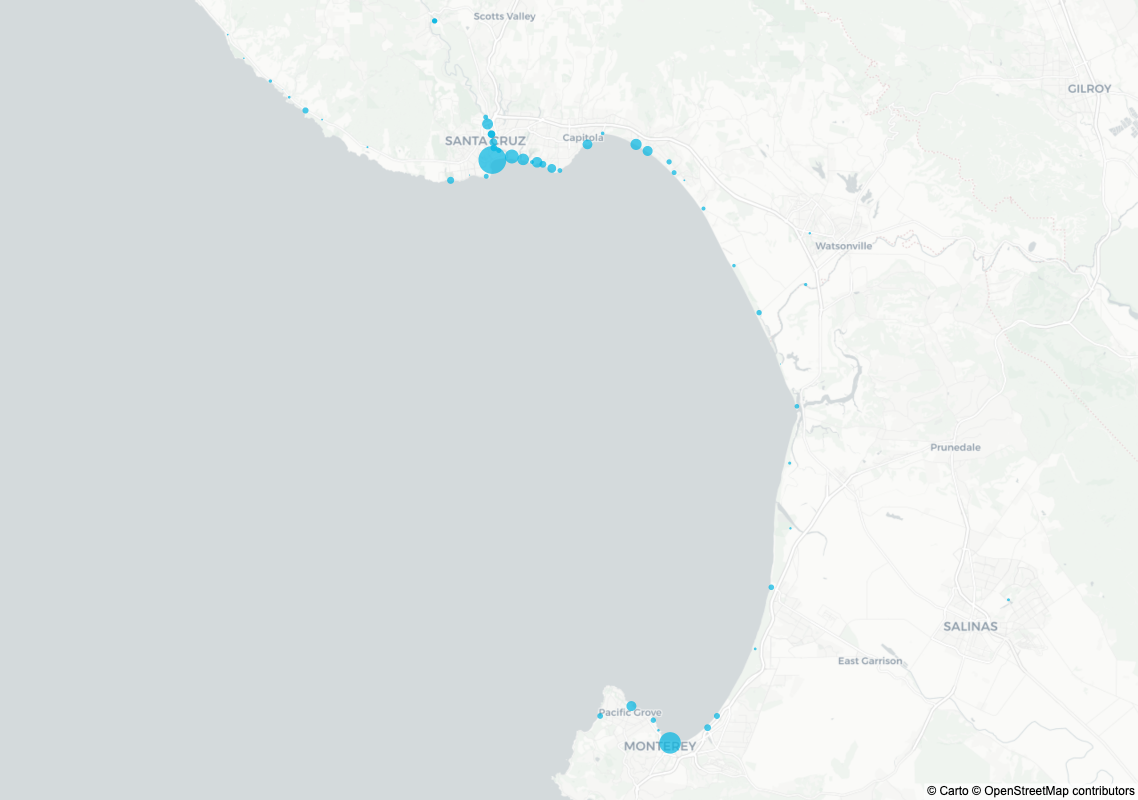

In [16]:
fig = graph_maker.cigarette_map()
fig.show()

The map above shows the sites where cigarette butts were collected in the years 2013-2023. The circles are centered on the cleanup site, and the size of the circles correspond to the number of cigarette butts cleaned up from that site. You can hover over the circle to get more information, and you can zoom in and out on the map by sliding down and up with two fingers on your trackpad. SLR stands for San Lorenzo River.

This plot is limited to sites with known coordinates, and coordinates successfully located with the geopy package.
(Note: I merged Corcoran Lagoon at 20th and 26th Ave to Corcoran Lagoon, and I merged two Del Monte Beach locations into one).

## Debris Caused by Smoking, 2013-2023

Let's look at the categories specifically related to smoking and see how they've changed over time. Since there is a correlation between number of items collected and number of volunteers, we'll look at number of items per volunteer for each year. The smoking related items in the data set are: **Cigarette Butts**, **Cigar Tips**, **E-Waste**, and **Tobacco**. The Tobacco category includes items such as packaging and wrappers. Since some data categories for some year were e.g. 'Other Tobacco (Packaging, Lighter, Etc.)' or 'Smoking, Tobacco, Vape Items (Not Butts)', this general Tobacco category may include some lighters and e-waste items.

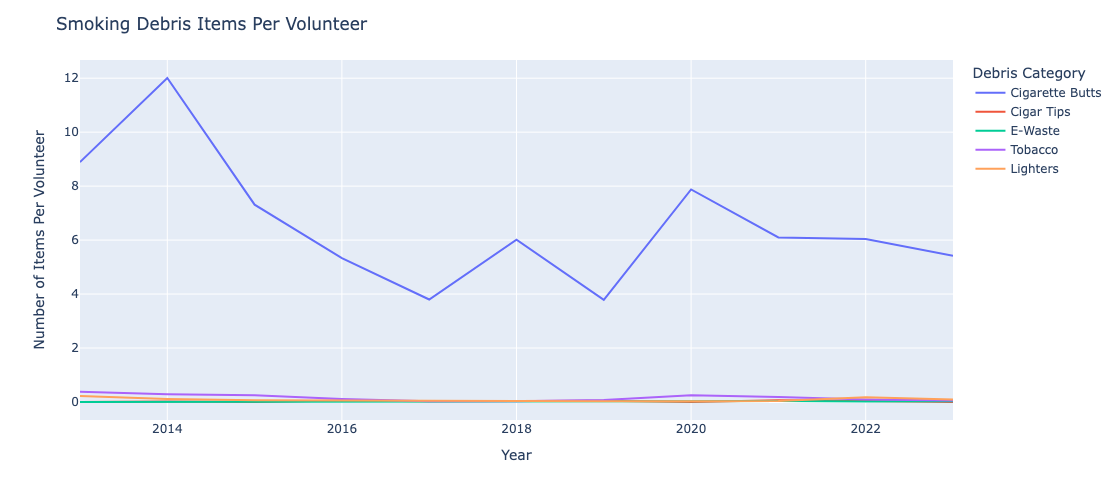

In [17]:
fig = graph_maker.smoking_line_graph()
fig.show()

Cigarette butts is by far the worst polluter among smoking categories and the second worst overall after plastic pieces.

## Smoking Ban on State Beaches

In 2020, a smoking ban on state beaches took effect. Here we separate the data into state beaches and not state beaches and look at the number of cigarette butts cleaned up per volunteer. The separation was made by searching for the keywords 'Beach' and 'State', so the cleanup site names needs to be verified to make sure 'State' is in the name if it's a state beach. Capitola and Cowell/Main beaches were excluded from the dataset since I believe there's been a ban on smoking there since 2004.

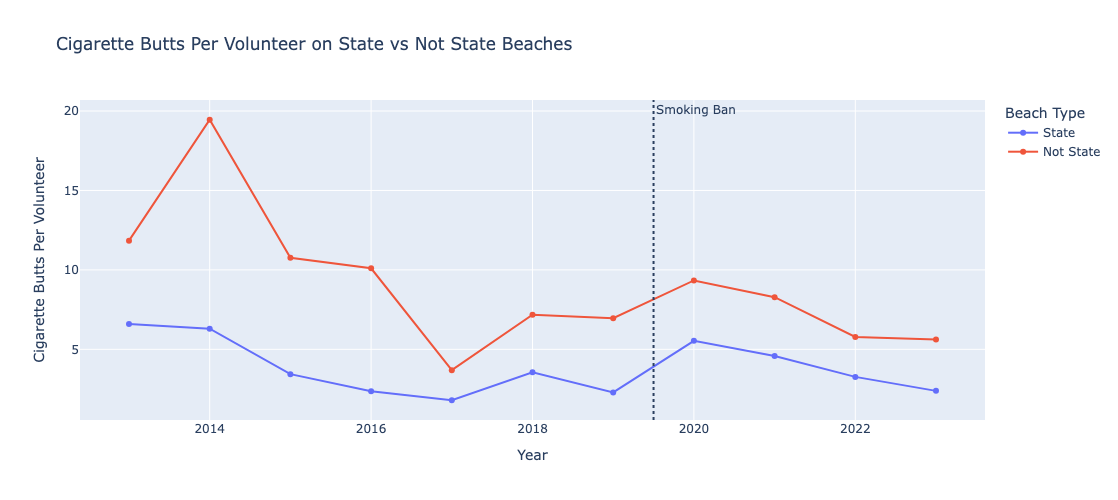

In [18]:
fig = graph_maker.smoking_state_beaches()
fig.show()

The dotted vertical line in the figure above is placed in between the aggregate results from 2019 and 2020 since the smoking ban on state beaches came into effect at the beginning of 2020. 
2020 was an unusual year and it's hard to tell what the effects of COVID-19 was on this data. But it looks like we may be seeing a decrease in the number of cigarette butts on both state beaches and otherwise after 2020, with fewer number of cigarette butts found on state beaches.
What I don't know is if state beaches are being cleaned up by state employees or other organizations, and if so, if they report the number of debris items they collect.

# Discussion

This notebook displays some of the key findings of the Save Our Shores coastal cleanup data, including totals of debris items grouped by material and activity, longitudinal analysis, as well as debris caused by smoking more specifically. It should be noted that (as often is the case) the bulk of the work consisted of data wrangling, and if you're interested in seeing how I extracted, transformed and loaded the data from non-standardized spreadsheets, please take a look at the [GitHub repository.](https://github.com/jennyfolkesson/saveOurShores/tree/main)

It's clear from the data that plastic pollution is by far the most common marine debris material collected by Save Our Shores. This aligns with findings that oceans have massive plastic pollution problem, and is made even worse due to the fact that plastics don't break down (biodegrade), they break up into smaller and smaller pieces. Microplastics (plastic pieces with diameters <5mm) are [omnipresent and consumed by animals and humans alike.](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9920460/). This implies that there's an urgent need to take action to reduce plastic consumption, which is the root cause of this massive problem.

Cigarette butts are by far the most common identifiable debris item collected on our beaches, and it's second only to plastic pieces (which is all types of plastic trash broken into smaller pieces) out of all debris categories. Despite a sligth potential downward trend in recent years of collected cigarette butts, they remain a massive cause of pollution globally, with [an estimated 4.5 trillion cigarette filters deposited into the environment annually.](https://ncbi.nlm.nih.gov/pmc/articles/PMC9340047/)
Save Our Shores is working to ban the sale of single-use cigarette filters in Santa Cruz County in the fall of 2024, and if you support their cause please consider [signing this survey.](https://saveourshores.org/sea-change-in-60-seconds/)
In short, cigarette butts are toxic pieces of single use plastics which fill no function other than giving smokers a false sense of security, and they have no place on our beaches or anywhere else.